# CS4465 Open Project - Sharpened Cosine Similarity

Name: Ritvik Raina

Student ID: 55828826

Implementation of Sharpened Cosine Similarity as an alternative to Convolutions

In [1]:
#code requires tensorflow 3.8
#used collab rather than jupyter notebook

#import relevant packages
import os
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import tensorflow.keras as keras
import tensorflow as tf

In [2]:
%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Loading

In [4]:
data = "/content/drive/MyDrive/CS4465 PROJECT"

In [5]:
Classes = ["Normal","Covid"]

#dataset - Normal and Covid

In [6]:
#path to image numpy arrays
normal_path = os.path.join(data,"Normal Images Array.npy")
covid_path = os.path.join(data, "Covid Images Array.npy")

In [7]:
#loading images array
normal_img = np.load(normal_path)
covid_img = np.load(covid_path)

In [8]:
num_normal = len(normal_img)
num_covid = len(covid_img)


print("Number of Normal Lung X-rays: {}".format(num_normal))
print("Number of Lung X-rays with COVID: {}".format(num_covid))
print("Total number of images: {}".format(num_normal+num_covid))

Number of Normal Lung X-rays: 6893
Number of Lung X-rays with COVID: 7593
Total number of images: 14486


In [9]:
#define vairables
BATCH = 16
img_size = 128
epochs = 10

In [10]:
#labeling as 1 for Covid and 0 for Normal
c_copy = covid_img
c_labels = ["1" for i in c_copy]
n_copy = normal_img
n_labels = ["0" for i in n_copy]


x = np.concatenate([c_copy, n_copy])
y = np.array((c_labels + n_labels), dtype=np.float32)
print(x.shape)
print(y.shape)

(14486, 128, 128, 1)
(14486,)


In [11]:
#train_test_split
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=101)

In [12]:
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, 2)
y_test = keras.utils.to_categorical(y_test, 2)

## Training Model

In [13]:
import math
import tensorflow.keras.layers as layers

In [14]:
#{pisoni2022sharpenedcossim,
#title={Sharpened Cosine Distance as an Alternative for Convolutions}, 
#     author={Raphael Pisoni},
#    year={2022},
#   note={\url{https://rpisoni.dev/posts/cossim-convolution/}},}

class CosSim2D(layers.Layer):
    def __init__(
        self,
        depthwise_separable=False,
        epsilon=1e-12,
        kernel=1,
        padding='valid',
        stride=1,
        units=32,
    ):
        super(CosSim2D, self).__init__()

        self.depthwise_separable = depthwise_separable
        self.epsilon = epsilon
        self.units = units
        self.stride = stride

        assert kernel in [1, 3, 5], "kernel of this size not supported"
        self.kernel_size = kernel
        if self.kernel_size == 1:
            self.stack = lambda x: x
        elif self.kernel_size == 3:
            self.stack = self.stack3x3
        elif self.kernel_size == 5:
            self.stack = self.stack5x5

        if padding == 'same':
            self.pad = self.kernel_size // 2
            self.pad_1 = 1
            self.clip = 0
        elif padding == 'valid':
            self.pad = 0
            self.pad_1 = 0
            self.clip = self.kernel_size // 2

    def build(self, input_shape):
        self.in_shape = input_shape
        self.out_y = math.ceil((self.in_shape[1] - 2*self.clip) / self.stride)
        self.out_x = math.ceil((self.in_shape[2] - 2*self.clip) / self.stride)
        self.flat_size = self.out_x * self.out_y
        self.channels = self.in_shape[3]

        if self.depthwise_separable:
            self.w = self.add_weight(
                shape=(1, tf.square(self.kernel_size), self.units),
                initializer="glorot_uniform",
                name='w',
                trainable=True,
            )
        else:
            w_shape = (
                1, self.channels * tf.square(self.kernel_size), self.units)
            self.w = self.add_weight(
                shape=w_shape,
                initializer="glorot_uniform",
                name='w',
                trainable=True,
            )

        p_init = tf.keras.initializers.Constant(value=2)
        self.p = self.add_weight(
            shape=(self.units,), initializer=p_init, trainable=True, name='p')

    @tf.function
    def l2_normal(self, x, axis=None, epsilon=1e-12):
        square_sum = tf.reduce_sum(tf.square(x), axis, keepdims=True)
        x_inv_norm = tf.sqrt(tf.maximum(square_sum, epsilon))
        return x_inv_norm

    @tf.function
    def sigplus(self, x):
        return tf.nn.sigmoid(x) * tf.nn.softplus(x)

    @tf.function
    def stack3x3(self, image):
        x = tf.shape(image)[2]
        y = tf.shape(image)[1]
        stack = tf.stack([
            # top row
            tf.pad(image[:, :y - 1 - self.clip:, :x - 1 - self.clip, :], tf.constant([[0, 0], [self.pad, 0], [self.pad, 0], [0, 0]])) [:, ::self.stride, ::self.stride, :],
            tf.pad(image[:, :y - 1 - self.clip, self.clip:x - self.clip, :], tf.constant([[0, 0], [self.pad, 0], [0, 0], [0, 0]])) [:, ::self.stride, ::self.stride, :],
            tf.pad(image[:, :y - 1 - self.clip, 1 + self.clip:, :], tf.constant([[0, 0], [self.pad, 0], [0, self.pad], [0, 0]])) [:, ::self.stride, ::self.stride, :],

            # middle row
            tf.pad(image[:, self.clip:y - self.clip, :x - 1 - self.clip, :], tf.constant([[0, 0], [0, 0], [self.pad, 0], [0, 0]])) [:, ::self.stride, ::self.stride, :],
            image[:, self.clip:y - self.clip:self.stride, self.clip:x - self.clip:self.stride, :],
            tf.pad(image[:, self.clip:y - self.clip, 1 + self.clip:, :], tf.constant([[0, 0], [0, 0], [0, self.pad], [0, 0]])) [:, ::self.stride, ::self.stride, :],

            # bottom row
            tf.pad(image[:, 1 + self.clip:, :x - 1 - self.clip, :], tf.constant([[0, 0], [0, self.pad], [self.pad, 0], [0, 0]])) [:, ::self.stride, ::self.stride, :],
            tf.pad(image[:, 1 + self.clip:, self.clip:x - self.clip, :], tf.constant([[0, 0], [0, self.pad], [0, 0], [0, 0]])) [:, ::self.stride, ::self.stride, :],
            tf.pad(image[:, 1 + self.clip:, 1 + self.clip:, :], tf.constant([[0, 0], [0, self.pad], [0, self.pad], [0, 0]])) [:, ::self.stride, ::self.stride, :]
        ], axis=3)
        return stack

    @tf.function
    def stack5x5(self, image):
        x = tf.shape(image)[2]
        y = tf.shape(image)[1]
        stack = tf.stack([
            # Row 0 (top row)
            tf.pad(image[:, :y - 2 - self.clip:, :x - 2 - self.clip, :], tf.constant([[0, 0], [self.pad, 0], [self.pad, 0], [0, 0]])) [:, ::self.stride, ::self.stride, :],
            tf.pad(image[:, :y - 2 - self.clip:, 1:x - 1 - self.clip, :], tf.constant([[0, 0], [self.pad, 0], [self.pad_1, self.pad_1], [0, 0]])) [:, ::self.stride, ::self.stride, :],
            tf.pad(image[:, :y - 2 - self.clip:, self.clip:x - self.clip, :], tf.constant([[0, 0], [self.pad, 0], [0, 0], [0, 0]])) [:, ::self.stride, ::self.stride, :],
            tf.pad(image[:, :y - 2 - self.clip:, 1 + self.clip:-1, :], tf.constant([[0, 0], [self.pad, 0], [self.pad_1, self.pad_1], [0, 0]])) [:, ::self.stride, ::self.stride, :],
            tf.pad(image[:, :y - 2 - self.clip:, 2 + self.clip: , :], tf.constant([[0, 0], [self.pad, 0], [0, self.pad], [0, 0]])) [:, ::self.stride, ::self.stride, :],

            # Row 1
            tf.pad(image[:, 1:y - 1 - self.clip:, :x - 2 - self.clip, :], tf.constant([[0, 0], [self.pad_1, self.pad_1], [self.pad, 0], [0, 0]])) [:, ::self.stride, ::self.stride, :],
            tf.pad(image[:, 1:y - 1 - self.clip:, 1:x - 1 - self.clip, :], tf.constant([[0, 0], [self.pad_1, self.pad_1], [self.pad_1, self.pad_1], [0, 0]])) [:, ::self.stride, ::self.stride, :],
            tf.pad(image[:, 1:y - 1 - self.clip:, self.clip:x - self.clip, :], tf.constant([[0, 0], [self.pad_1, self.pad_1], [0, 0], [0, 0]])) [:, ::self.stride, ::self.stride, :],
            tf.pad(image[:, 1:y - 1 - self.clip:, 1 + self.clip:-1, :], tf.constant([[0, 0], [self.pad_1, self.pad_1], [self.pad_1, self.pad_1], [0, 0]])) [:, ::self.stride, ::self.stride, :],
            tf.pad(image[:, 1:y - 1 - self.clip:, 2 + self.clip:, :], tf.constant([[0, 0], [self.pad_1, self.pad_1], [0, self.pad], [0, 0]])) [:, ::self.stride, ::self.stride, :],

            # Row 2 (center row)
            tf.pad(image[:, self.clip:y - self.clip, :x - 2 - self.clip, :], tf.constant([[0, 0], [0, 0], [self.pad, 0], [0, 0]])) [:, ::self.stride, ::self.stride, :],
            tf.pad(image[:, self.clip:y - self.clip, 1:x - 1 - self.clip, :], tf.constant([[0, 0], [0, 0], [self.pad_1, self.pad_1], [0, 0]])) [:, ::self.stride, ::self.stride, :],
            image[:, self.clip:y - self.clip, self.clip:x - self.clip, :][:, ::self.stride, ::self.stride, :],
            tf.pad(image[:, self.clip:y - self.clip, 1 + self.clip:-1, :], tf.constant([[0, 0], [0, 0], [self.pad_1, self.pad_1], [0, 0]]))[:, ::self.stride, ::self.stride, :],
            tf.pad(image[:, self.clip:y - self.clip, 2 + self.clip:, :], tf.constant([[0, 0], [0, 0], [0, self.pad], [0, 0]]))[:, ::self.stride, ::self.stride, :],

            # Row 3
            tf.pad(image[:, 1 + self.clip:-1, :x - 2 - self.clip, :], tf.constant([[0, 0], [self.pad_1, self.pad_1], [self.pad, 0], [0, 0]]))[:, ::self.stride, ::self.stride, :],
            tf.pad(image[:, 1 + self.clip:-1, 1:x - 1 - self.clip, :], tf.constant([[0, 0], [self.pad_1, self.pad_1], [self.pad_1, self.pad_1], [0, 0]]))[:, ::self.stride, ::self.stride, :],
            tf.pad(image[:, 1 + self.clip:-1, self.clip:x - self.clip, :], tf.constant([[0, 0], [self.pad_1, self.pad_1], [0, 0], [0, 0]]))[:, ::self.stride, ::self.stride, :],
            tf.pad(image[:, 1 + self.clip:-1, 1 + self.clip:-1, :], tf.constant([[0, 0], [self.pad_1, self.pad_1], [self.pad_1, self.pad_1], [0, 0]]))[:, ::self.stride, ::self.stride, :],
            tf.pad(image[:, 1 + self.clip:-1, 2 + self.clip:, :], tf.constant([[0, 0], [self.pad_1, self.pad_1], [0, self.pad], [0, 0]]))[:, ::self.stride, ::self.stride, :],

            # Row 4 (bottom row)
            tf.pad(image[:, 2 + self.clip:, :x - 2 - self.clip, :], tf.constant([[0, 0], [0, self.pad], [self.pad, 0], [0, 0]]))[:, ::self.stride, ::self.stride, :],
            tf.pad(image[:, 2 + self.clip:, 1:x - 1 - self.clip, :], tf.constant([[0, 0], [0, self.pad], [self.pad_1, self.pad_1], [0, 0]]))[:, ::self.stride, ::self.stride, :],
            tf.pad(image[:, 2 + self.clip:, self.clip:x - self.clip, :], tf.constant([[0, 0], [0, self.pad], [0, 0], [0, 0]]))[:, ::self.stride, ::self.stride, :],
            tf.pad(image[:, 2 + self.clip:, 1 + self.clip:-1, :], tf.constant([[0, 0], [0, self.pad], [self.pad_1, self.pad_1], [0, 0]]))[:, ::self.stride, ::self.stride, :],
            tf.pad(image[:, 2 + self.clip:, 2 + self.clip:, :], tf.constant([[0, 0], [0, self.pad], [0, self.pad], [0, 0]]))[:, ::self.stride, ::self.stride, :],
        ], axis=3)
        return stack

    def call_body(self, inputs):
        channels = tf.shape(inputs)[-1]
        x = self.stack(inputs)
        x = tf.reshape(
            x, (-1, self.flat_size, channels * tf.square(self.kernel_size)))
        x_norm = (self.l2_normal(x, axis=2, epsilon=self.epsilon))
        w_norm = (self.l2_normal(self.w, axis=1, epsilon=self.epsilon))
        x = tf.matmul(x / x_norm, self.w / w_norm)
        sign = tf.sign(x)
        x = tf.abs(x) + self.epsilon
        x = tf.pow(x, self.sigplus(self.p))
        x = sign * x
        x = tf.reshape(x, (-1, self.out_y, self.out_x, self.units))
        return x

    @tf.function
    def call(self, inputs, training=None):
        if self.depthwise_separable:
            channels = tf.shape(inputs)[-1]
            x = tf.vectorized_map(
                self.call_body,
                tf.expand_dims(tf.transpose(inputs, (3,0,1,2)), axis=-1))
            s = tf.shape(x)
            x = tf.transpose(x, (1,2,3,4,0))
            x = tf.reshape(
                x, (-1, self.out_y, self.out_x, self.channels * self.units))
            return x
        else:
            x = self.call_body(inputs)
            return x

In [15]:
#{pisoni2022sharpenedcossim,
#title={Sharpened Cosine Distance as an Alternative for Convolutions}, 
 #     author={Raphael Pisoni},
  #    year={2022},
   #   note={\url{https://rpisoni.dev/posts/cossim-convolution/}},}
   
class MaxAbsPool2D(layers.Layer):
    """
    Similar to Max Pooling, except that the value with the largest magnitude
    is preserved. -2 beats a 1.5.
    """
    def __init__(self, pool_size, pad_to_fit=False):
        super(MaxAbsPool2D, self).__init__()
        self.pad = pad_to_fit
        self.pool_size = pool_size

    def compute_output_shape(self, in_shape):
        if self.pad:
            return (
                in_shape[0],
                tf.math.ceil(in_shape[1] / self.pool_size),
                tf.math.ceil(in_shape[2] / self.pool_size),
                in_shape[3])
        return (
            in_shape[0],
            (in_shape[1] // self.pool_size),
            (in_shape[2] // self.pool_size),
            in_shape[3])

    def compute_padding(self, in_shape):
        mod_y = in_shape[1] % self.pool_size
        y1 = mod_y // 2
        y2 = mod_y - y1
        mod_x = in_shape[2] % self.pool_size
        x1 = mod_x // 2
        x2 = mod_x - x1
        self.padding = ((0,0), (y1, y2), (x1, x2), (0,0))

    def build(self, input_shape):
        self.in_shape = input_shape
        self.out_shape = self.compute_output_shape(self.in_shape)
        self.compute_padding(self.in_shape)

    @tf.function
    def stack(self, inputs):
        if self.pad:
            inputs = tf.pad(inputs, self.padding)
        batch_size = tf.shape(inputs)[0]
        max_height = (tf.shape(inputs)[1] // self.pool_size) * self.pool_size
        max_width = (tf.shape(inputs)[2] // self.pool_size) * self.pool_size
        stack = tf.stack(
            [inputs[
                :, i:max_height:self.pool_size, j:max_width:self.pool_size, :]
                for i in range(self.pool_size)
                for j in range(self.pool_size)],
            axis=-1)
        return stack

    @tf.function
    def call(self, inputs, training=None):
        stacked = self.stack(inputs)
        inds = tf.argmax(tf.abs(stacked), axis=-1, output_type=tf.int32)
        ks = tf.shape(stacked)
        idx = tf.stack([
            *tf.meshgrid(
                tf.range(0, ks[0]),
                tf.range(0, ks[1]),
                tf.range(0, ks[2]),
                tf.range(0, ks[3]),
                indexing='ij'
            ), inds],
            axis=-1)

        x = tf.gather_nd(stacked, idx)
        x = tf.reshape(x, (-1, *self.out_shape[1:]))
        return x

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPool2D, InputLayer

In [17]:
#instantiate
model = Sequential([
                    InputLayer(input_shape=(img_size,img_size,1)),
                    CosSim2D(kernel=1, units=16, padding="valid"),
                    CosSim2D(kernel=3, units=16, padding="valid"), #bottlenecking
                    MaxAbsPool2D(2,True),

                    CosSim2D(kernel=3, units=32),
                    CosSim2D(kernel=5, units=32),
                    MaxAbsPool2D(2,True),
                    
                    CosSim2D(kernel=5, units=64),
                    MaxAbsPool2D(2,True),

                    Flatten(),
                    Dense(32, activation=None),
                    Dense(2, activation=None),
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cos_sim2d (CosSim2D)        (None, 128, 128, 16)      32        
                                                                 
 cos_sim2d_1 (CosSim2D)      (None, 126, 126, 16)      2320      
                                                                 
 max_abs_pool2d (MaxAbsPool2  (None, 63, 63, 16)       0         
 D)                                                              
                                                                 
 cos_sim2d_2 (CosSim2D)      (None, 61, 61, 32)        4640      
                                                                 
 cos_sim2d_3 (CosSim2D)      (None, 57, 57, 32)        25632     
                                                                 
 max_abs_pool2d_1 (MaxAbsPoo  (None, 29, 29, 32)       0         
 l2D)                                                   

In [18]:
#defining a model check point and saving the best weights
checkpoint_path = 'training_3/cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_dir,
    save_weights_only=True,
    monitor='val_accuracy',
    save_best_only=True)

In [19]:
lr = 0.05
label_smoothing = 0.3

In [20]:
#optimze the learning rate
def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer._decayed_lr(tf.float32)
    return lr

optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
loss = tf.keras.losses.CategoricalCrossentropy(
    from_logits=True, label_smoothing=label_smoothing)

In [21]:
model.compile(loss=loss,optimizer=optimizer,
    metrics=[get_lr_metric(optimizer), "accuracy"],
    run_eagerly=False)

In [22]:
#training the model
results_history = model.fit(x_train, y_train,
                            batch_size=32,
                            epochs=epochs,
                            shuffle=True,
                            callbacks=[checkpoint],
                            validation_data=(x_test, y_test))

Epoch 1/10
363/363 [==============================] - 194s 510ms/step - loss: 2.2504 - lr: 0.0500 - accuracy: 0.5366 - val_loss: 0.6552 - val_lr: 0.0500 - val_accuracy: 0.5280
Epoch 2/10
363/363 [==============================] - 185s 510ms/step - loss: 0.6079 - lr: 0.0500 - accuracy: 0.7921 - val_loss: 0.5953 - val_lr: 0.0500 - val_accuracy: 0.8023
Epoch 3/10
363/363 [==============================] - 184s 508ms/step - loss: 0.5970 - lr: 0.0500 - accuracy: 0.8033 - val_loss: 0.5932 - val_lr: 0.0500 - val_accuracy: 0.8006
Epoch 4/10
363/363 [==============================] - 183s 505ms/step - loss: 0.5953 - lr: 0.0500 - accuracy: 0.8066 - val_loss: 0.5909 - val_lr: 0.0500 - val_accuracy: 0.8081
Epoch 5/10
363/363 [==============================] - 184s 506ms/step - loss: 0.5946 - lr: 0.0500 - accuracy: 0.8103 - val_loss: 0.5926 - val_lr: 0.0500 - val_accuracy: 0.8209
Epoch 6/10
363/363 [==============================] - 183s 505ms/step - loss: 0.5942 - lr: 0.0500 - accuracy: 0.8150 - v

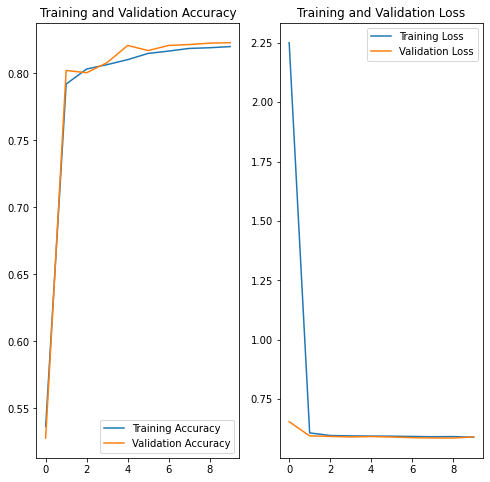

In [23]:
#VISUALIZE the training accuracy and loss over the epochs

acc = results_history.history['accuracy']
val_acc = results_history.history['val_accuracy']

loss = results_history.history['loss']
val_loss = results_history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [24]:
model.load_weights(checkpoint_dir)
evaluation_results = model.evaluate(x_test, y_test)
print(f"test accuracy: {evaluation_results[2]:.04}")
print(f"loss on test data: {evaluation_results[0]:.04}")

91/91 [==============================] - 18s 194ms/step - loss: 0.5911 - lr: 0.0500 - accuracy: 0.8230
test accuracy: 0.823
loss on test data: 0.5911


In [26]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=101)
#train test split again, because model.predict() 
#gives an error with binary class matrices

y_pred = model.predict(x_test)
predicted = np.argmax(y_pred, axis=-1)

from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test,predicted))

              precision    recall  f1-score   support

         0.0       0.87      0.74      0.80      1364
         1.0       0.79      0.90      0.84      1534

    accuracy                           0.82      2898
   macro avg       0.83      0.82      0.82      2898
weighted avg       0.83      0.82      0.82      2898



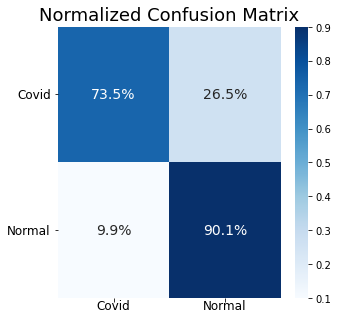

In [27]:
# Plot the confusion matrix
plt.figure(figsize=(5,5))
sns.heatmap(confusion_matrix(y_test, predicted, normalize='true'),
            fmt='.1%',
            annot=True,
            cmap="Blues",
            xticklabels=["Covid","Normal"],
            yticklabels=["Covid","Normal"],
            annot_kws={"size": 14})
plt.title('Normalized Confusion Matrix', {'fontsize':18})
plt.yticks(np.arange(2)+0.5,rotation=0, fontsize="12", va="center")
plt.xticks(np.arange(2)+0.5,rotation=0, fontsize="12", va="center")
plt.show()